# **Outline**

- Downloading and importing a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting, hyperparameter tuning & regularization
- Making predictions on single inputs

# **Problem Statement**

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:
>
> As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow. 


# **Importing Dependencies**

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

# **Accessing Dataset**

In [4]:
df = pd.read_csv('dataset/weatherAUS.csv')
df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


Each row shows the measurements for a given date at a given location. The last column "RainTomorrow" contains the value to be predicted.

Let's check the column types of the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Let's drop any rows where the value of the target column `RainTomorrow` in empty.

In [6]:
df.dropna(subset=['RainTomorrow'], inplace=True)
df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


# **Preparing the Data for Training**

We'll perform the following steps to prepare the dataset for training:

1. Create a train/test/validation split
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

## **Training, Validation and Test Sets**

For training and testing purposes of our model, we should have our data broken down into three distinct dataset splits.

Training set of data that is used to train and make the model learn the hidden features/patterns in the data.

- The training set should have a diversified set of inputs so that the model is trained in all scenarios and can predict any unseen data sample that may appear in the future.

Validation set is a set of data, separate from the training set, that is used to validate our model performance during training.

- This validation process gives information that helps us tune the model’s hyperparameters and configurations accordingly. 
- It is like a critic telling us whether the training is moving in the right direction or not.
- The main idea of splitting the dataset into a validation set is to prevent our model from overfitting.

The test set is a separate set of data used to test the model after completing the training.

- It provides an unbiased final model performance metric in terms of accuracy, precision, etc.

One has to come to a split percentage that suits the requirements and meets the model’s needs, the major concerns while deciding on the optimum split are:

- If there is less training data, the machine learning model will show high variance in training.
- With less testing data/validation data, your model evaluation/model performance statistic like accuracy, precision, recall, and F1 score will have greater variance.

There is no optimal split percentage but in general, putting 80% of the data in the training set, 10%  in the validation set, and 10% in the test set is a good split to start with.


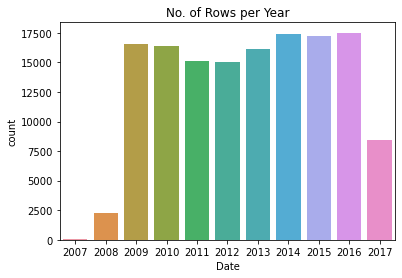

In [7]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(df.Date).dt.year);

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

We'll use the data till 2014 for the training set, data from 2015 for the validation set, and the data from 2016 & 2017 for the test set.  

In [8]:
year = pd.to_datetime(df.Date).dt.year

train_df = df[year < 2015]
val_df = df[year == 2015]
test_df = df[year > 2015]

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


## **Input and Target Columns**

Let's identify the input and target columns.

In [9]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's also identify the numeric and categorical columns.

In [10]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

print(numeric_cols)
print(categorical_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


## **Imputing missing numeric values**

In [11]:
from sklearn.impute import SimpleImputer

In [12]:
train_inputs[numeric_cols].isna().sum()

MinTemp            434
MaxTemp            198
Rainfall          1000
Evaporation      37110
Sunshine         40696
WindGustSpeed     6902
WindSpeed9am      1133
WindSpeed3pm      1140
Humidity9am       1265
Humidity3pm       1186
Pressure9am       9345
Pressure3pm       9309
Cloud9am         35764
Cloud3pm         36766
Temp9am            783
Temp3pm            663
dtype: int64

In [13]:
imputer = SimpleImputer(strategy = 'mean').fit(df[numeric_cols])

train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## **Scaling Numeric Features**

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler().fit(df[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

val_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


## **Encoding Categorical Data**

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(df[categorical_cols])

encoded_cols = list(encoder.get_feature_names(categorical_cols))

train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

test_inputs

c:\Users\Dheeraj\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
c:\Users\Dheeraj\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
c:\Users\Dheeraj\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
2498,Albury,0.681604,0.801512,0.000000,0.037723,0.525852,ENE,0.372093,NaN,ESE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037723,0.525852,SSE,0.341085,SSE,SE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037723,0.525852,ENE,0.325581,ESE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2501,Albury,0.608491,0.538752,0.042049,0.037723,0.525852,SSE,0.255814,SE,SSE,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2502,Albury,0.566038,0.523629,0.018329,0.037723,0.525852,ENE,0.193798,SE,SSE,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,0.283019,0.502836,0.000000,0.037723,0.525852,E,0.193798,ESE,E,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145455,Uluru,0.266509,0.533081,0.000000,0.037723,0.525852,E,0.193798,SE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145456,Uluru,0.285377,0.568998,0.000000,0.037723,0.525852,NNW,0.124031,SE,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145457,Uluru,0.327830,0.599244,0.000000,0.037723,0.525852,N,0.240310,SE,WNW,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.

In [18]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X_test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
2498,0.681604,0.801512,0.000000,0.037723,0.525852,0.372093,0.000000,0.080460,0.46,0.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2499,0.693396,0.725898,0.001078,0.037723,0.525852,0.341085,0.069231,0.195402,0.54,0.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2500,0.634434,0.527410,0.005930,0.037723,0.525852,0.325581,0.084615,0.448276,0.62,0.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2501,0.608491,0.538752,0.042049,0.037723,0.525852,0.255814,0.069231,0.195402,0.74,0.65,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2502,0.566038,0.523629,0.018329,0.037723,0.525852,0.193798,0.046154,0.103448,0.92,0.63,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,0.283019,0.502836,0.000000,0.037723,0.525852,0.193798,0.115385,0.149425,0.59,0.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145455,0.266509,0.533081,0.000000,0.037723,0.525852,0.193798,0.100000,0.126437,0.51,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145456,0.285377,0.568998,0.000000,0.037723,0.525852,0.124031,0.100000,0.103448,0.56,0.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145457,0.327830,0.599244,0.000000,0.037723,0.525852,0.240310,0.069231,0.103448,0.53,0.24,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# **Training and Visualizing Decision Trees**

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

## **Training**

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
model = DecisionTreeClassifier(random_state=42)

In [21]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

An optimal decision tree has now been created using the training data.

## **Evaluation**

Let's evaluate the decision tree using the accuracy score.

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [23]:
train_preds = model.predict(X_train)
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [24]:
pd.value_counts(train_preds)

No     76707
Yes    22281
dtype: int64

The decision tree also returns probabilities for each prediction.

In [25]:
train_probs = model.predict_proba(X_train)
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [26]:
accuracy_score(train_targets, train_preds)

0.9999797955307714

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [27]:
model.score(X_val, val_targets)

0.7921188555510418

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [28]:
val_targets.value_counts() / len(val_targets)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called **overfitting**, and reducing overfitting is one of the most important parts of any machine learning project.

## **Visualization**

We can visualize the decision tree _learned_ from the training data.

In [29]:
from sklearn.tree import plot_tree, export_text

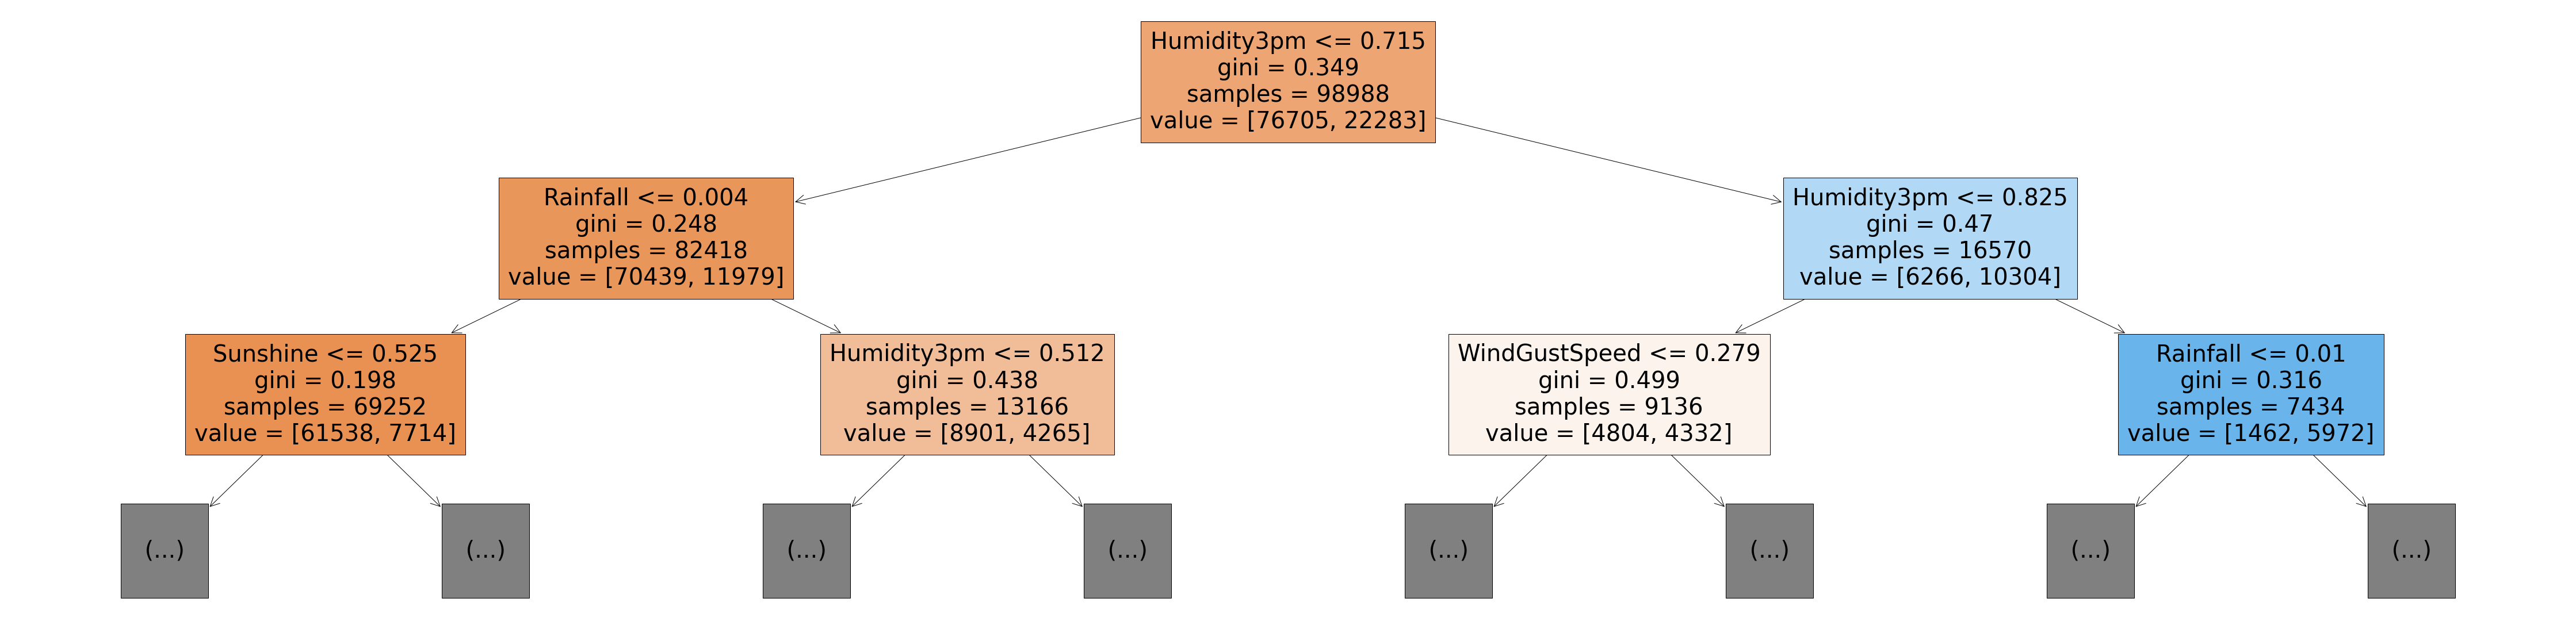

In [30]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No".

### **How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Other loss function can be the check of entropy (degree of randomness).

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. 

In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">


Let's check the depth of the tree that was created.

In [31]:
model.tree_.max_depth

48

We can also display the tree as text, which can be easier to follow for deeper trees.

In [32]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

### **Feature Importance**

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [33]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

Let's turn this into a dataframe and visualize the most important features.

In [37]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
8,Humidity9am,0.040218
14,Temp9am,0.035000
0,MinTemp,0.034894
10,Pressure9am,0.034415
1,MaxTemp,0.032361


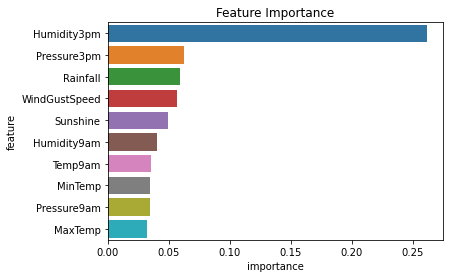

In [38]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## **Hyperparameter Tuning and Overfitting**

Sometimes decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy be only marginally better than a dumb baseline model. This phenomenon is called overfitting. 

The process of reducing overfitting is known as _regularlization_.

The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [39]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    al

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data). 

We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization.

Let's experiment with different depths using a helper function.

In [50]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [51]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

Wall time: 53.2 s


In [52]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


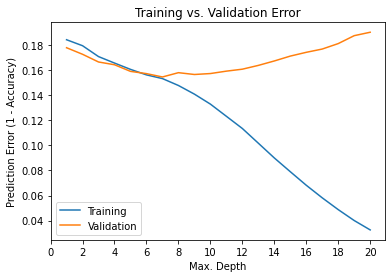

In [53]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

In [54]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8453949277465034

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

Let's create a helper function for the same as well.

In [62]:
def max_leaf_nodes_error(mln):
    model = DecisionTreeClassifier(max_leaf_nodes=mln, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'Max Leaf Node': mln, 'Training Error': train_acc, 'Validation Error': val_acc}

In [63]:
%%time
errors_df = pd.DataFrame([max_leaf_nodes_error(mln) for mln in range(2, 21)])

Wall time: 21.8 s


In [64]:
errors_df

,Max Leaf Node,Training Error,Validation Error
0,2,0.184315,0.177935
1,3,0.184315,0.177935
2,4,0.179547,0.172712
3,5,0.179547,0.172712
4,6,0.179547,0.172712
5,7,0.179547,0.172712
6,8,0.170869,0.166560
7,9,0.170869,0.166560
8,10,0.167061,0.164761
9,11,0.167061,0.164761


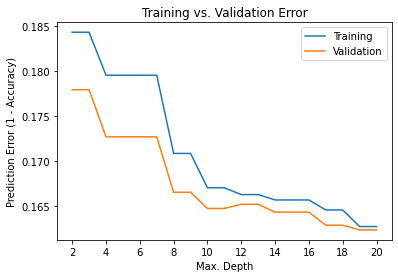

In [65]:
plt.figure()
plt.plot(errors_df['Max Leaf Node'], errors_df['Training Error'])
plt.plot(errors_df['Max Leaf Node'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(2,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

A more advanced technique (but less commonly used technique) for reducing overfitting in decision trees is known as **cost-complexity pruning**. 

Learn more about it here: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html.

# **Training a Random Forest**

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the **wisdom of the crowd**:

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">

The Random Forest can be used as Classifier or Regressor when used as classifier the voting is done and when used as Regressor the average is taken.

We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [68]:
%%time
model.fit(X_train, train_targets)

Wall time: 16.2 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [70]:
model.score(X_train, train_targets)

0.9999494888269285

In [69]:
model.score(X_val, val_targets)

0.8566537055307295

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far.

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called **bootstrapping**. 

For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of the training set, and some rows randomly get higher weightage than others.

In [71]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

We can can access individual decision trees using `model.estimators_`

In [76]:
model.estimators_, len(model.estimators_)

([DecisionTreeClassifier(max_features='auto', random_state=1608637542),
  DecisionTreeClassifier(max_features='auto', random_state=1273642419),
  DecisionTreeClassifier(max_features='auto', random_state=1935803228),
  DecisionTreeClassifier(max_features='auto', random_state=787846414),
  DecisionTreeClassifier(max_features='auto', random_state=996406378),
  DecisionTreeClassifier(max_features='auto', random_state=1201263687),
  DecisionTreeClassifier(max_features='auto', random_state=423734972),
  DecisionTreeClassifier(max_features='auto', random_state=415968276),
  DecisionTreeClassifier(max_features='auto', random_state=670094950),
  DecisionTreeClassifier(max_features='auto', random_state=1914837113),
  DecisionTreeClassifier(max_features='auto', random_state=669991378),
  DecisionTreeClassifier(max_features='auto', random_state=429389014),
  DecisionTreeClassifier(max_features='auto', random_state=249467210),
  DecisionTreeClassifier(max_features='auto', random_state=1972458954),


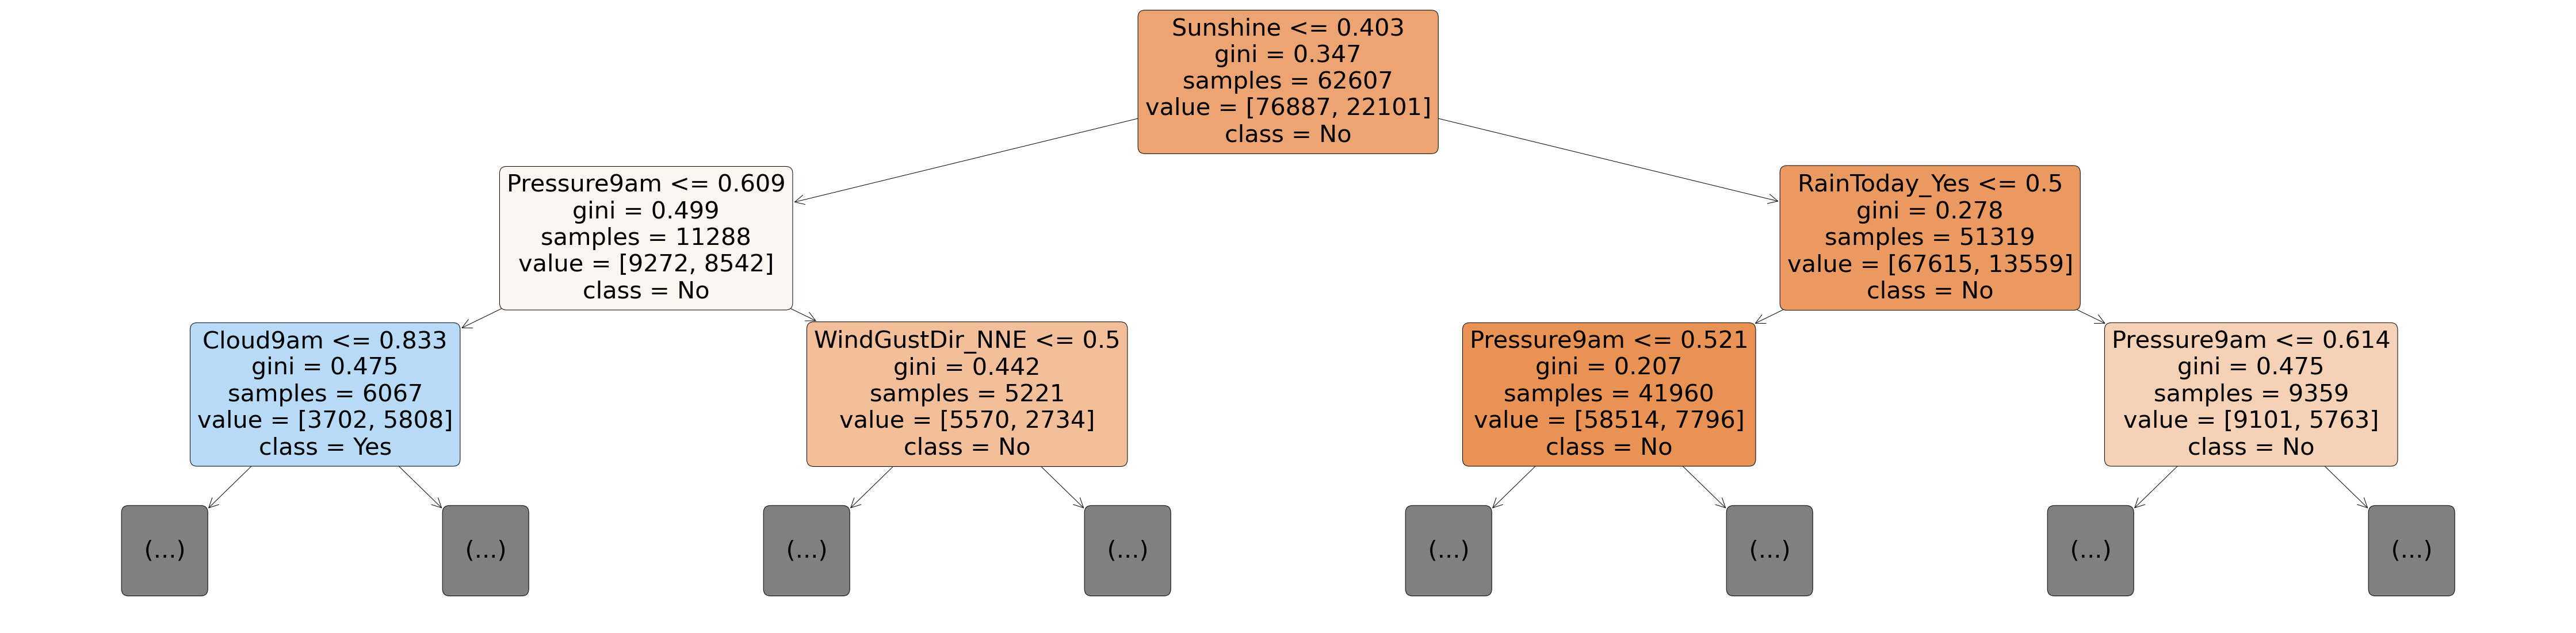

In [74]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

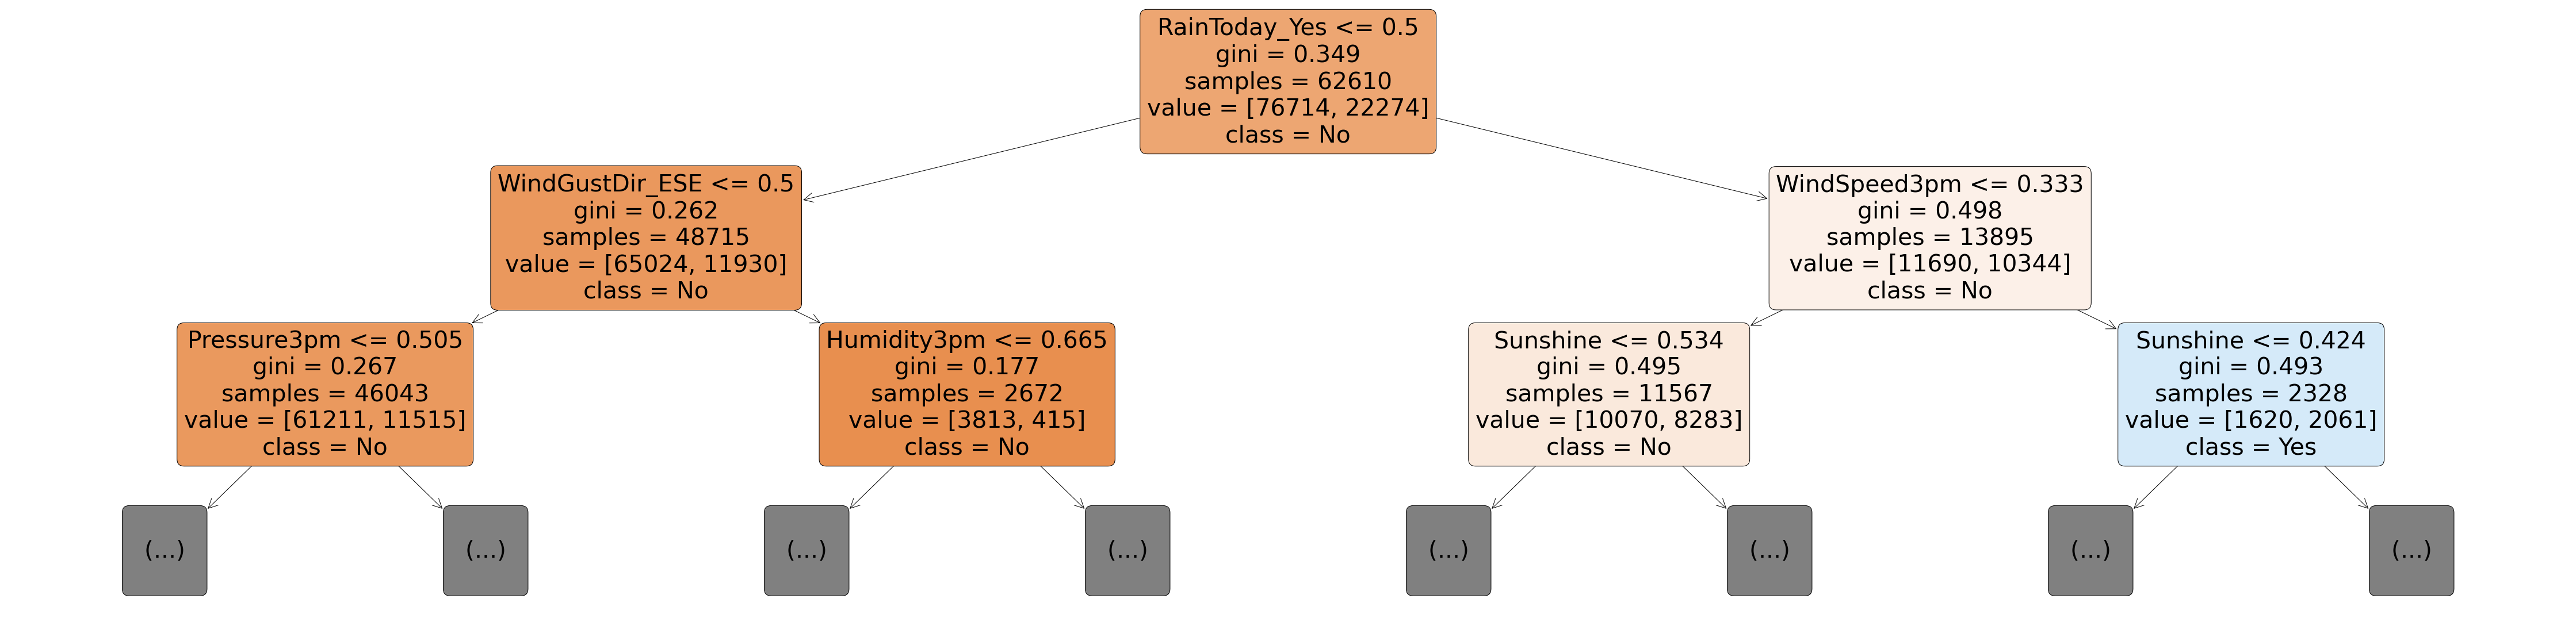

In [75]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [79]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df

,feature,importance
9,Humidity3pm,0.139904
4,Sunshine,0.053696
11,Pressure3pm,0.052713
8,Humidity9am,0.050051
2,Rainfall,0.048077
...,...,...
55,Location_Townsville,0.000702
19,Location_AliceSprings,0.000607
41,Location_Nhil,0.000544
32,Location_Katherine,0.000287


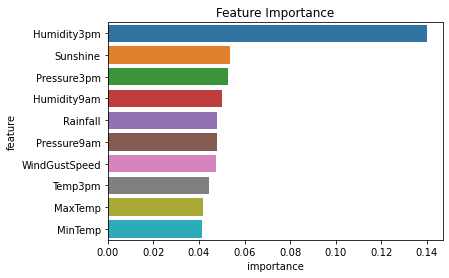

In [80]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that the distribution is a lot less skewed than that for a single decision tree.

## **Hyperparameter Tuning with Random Forests**

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests.

In [81]:
?RandomForestClassifier

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The nu

Let's create a base model with which we can compare models with tuned hyperparameters.

In [82]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [83]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)
base_train_acc, base_val_acc

(0.9999494888269285, 0.8566537055307295)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. 

The default value is 100. 

For larger datasets, it helps to have a greater number of estimators. 

As a general rule, try to have as few estimators as needed.

In [88]:
def testEstimators(n):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=n).fit(X_train, train_targets)
    train_acc = model.score(X_train, train_targets)
    val_acc = model.score(X_val, val_targets)
    return {"estimators": n, "training accuracy": train_acc, "validation accuracy": val_acc}

In [89]:
testEstimators(10)

{'estimators': 10,
 'training accuracy': 0.986958015112943,
 'validation accuracy': 0.8485868492832686}

```py
%%time
estimator_variation_df = pd.DataFrame([testEstimators(n) for n in range(2,200)])
plt.figure()
plt.plot(estimator_variation_df['estimators'], errors_df['training accuracy'])
plt.plot(errors_df['estimators'], errors_df['validation accuracy'])
plt.title('Training vs. Validation Accuracy')
plt.xticks(range(2,200, 2))
plt.xlabel('Estimators')
plt.ylabel('Prediction Accuracy')
plt.legend(['Training', 'Validation'])
```

This can be used to check the variation in accuracy with different estimator values from 2-200 but remember this takes a hell lot of time to compute.

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. 

By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Let's define a helper function `test_params` to make it easy to test hyperparameters.

In [92]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [93]:
test_params(max_features='log2')

(0.9999595910615429, 0.8558992513493123)

In [94]:
test_params(max_features=3)

(0.9999494888269285, 0.8543323080494458)

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. 

You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [95]:
test_params(min_samples_split=3, min_samples_leaf=2)

(0.9625005051117307, 0.8565956705936975)

In [96]:
test_params(min_samples_split=100, min_samples_leaf=60)

(0.8495676243585081, 0.8451047530613429)

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [98]:
test_params(n_estimators=500,
            max_features=7,
            max_depth=30, 
            class_weight={'No': 1, 'Yes': 1.5})

(0.9920192346547057, 0.8563054959085369)

We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest.

Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests in this case), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

## **Strategy for Tuning Hyperparameters**

Here's a good strategy for tuning hyperparameters:

1. Tune the most important/impactful hyperparameter first e.g. `n_estimators`

2. With the best value of the first hyperparameter, tune the next most impactful hyperparameter

3. And so on, keep training the next most impactful parameters with the best values for previous parameters...

4. Then, go back to the top and further tune each parameter again for further marginal gains

Keep your ideas and experiments organized using an experiment tracking sheet: https://bit.ly/mltrackingsheet


Your first objective should be make the training loss as low as possible (even if the validation loss is very large), and then try to regularize the model to slowly decrease the valiadation loss while increasing the training loss.


Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter

## **Making Predictions on New Inputs**

Let's define a helper function to make predictions on new inputs.

In [99]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [101]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(model, new_input)

c:\Users\Dheeraj\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


('Yes', 0.8)

## **Saving and Loading Trained Models**

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

In [102]:
import joblib

In [105]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(aussie_rain, './saved_model/aussie_rain_random_forest.joblib')

['./saved_model/aussie_rain_random_forest.joblib']

In [107]:
aussie_rain_rf = joblib.load('./saved_model/aussie_rain_random_forest.joblib')

In [110]:
test_preds = aussie_rain_rf['model'].predict(X_test)
accuracy_score(test_targets, test_preds)

0.8447678447678447

## Revision Questions
1.	What is a decision tree model?
2.	What is <code>DecisionTreeClassifier()</code>?
3.	Can we use decision tree only for Classifier? 
4.	How can you visualize the decision tree?
5.	What is <code>max_depth</code> in decision tree?
6.	What is gini index?
7.	What is feature importance?
8.	What is overfitting? What could be the reason for overfitting?
9.	What is hyperparameter tuning?
10.	What is one way to control the complexity of the decision tree?
11.	What is a random forest model?
12.	What is <code>RandomForestClassifier()</code>?
13.	What is <code>model.score()</code>?
14.	What is generalization?
15.	What is ensembling?
16.	What is <code>n_estimators</code> in hyperparameter tuning of random forests?
17.	What is underfitting?
18.	What does <code>max_features</code> parameter do?
19.	What are some features that help in controlling the threshold for splitting nodes in decision tree?
20.	What is bootstrapping? What is <code>max_samples</code> parameter in bootstrapping?
21.	What is <code>class_weight</code> parameter?
22.	You may or may not a see a significant improvement in the accuracy score with hyperparameter tuning. What could be the possible reasons for that?